In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import sklearn

In [2]:
df_featuresonly = pd.read_excel("wc_data_ready_featuresonly.xlsx", engine="openpyxl")
df_featurestarget = pd.read_excel("wc_data_ready_features_target.xlsx", engine="openpyxl")

(target classes)  
0 is cloudy  
1 is rainy  
2 is snowy  
3 is sunny

As decided on 10.1, to make the prediction more meaningful I'll now remove the cloud cover and visibility features, and continue that way.  

In [3]:
df_featuresonly.drop(
    ["Visibility (km)", "Cloud Cover_clear", "Cloud Cover_cloudy", "Cloud Cover_overcast", 
     "Cloud Cover_partly cloudy"], axis=1, inplace=True)
df_featurestarget.drop(
    ["Visibility (km)", "Cloud Cover_clear", "Cloud Cover_cloudy", "Cloud Cover_overcast", 
     "Cloud Cover_partly cloudy"], axis=1, inplace=True)

In [4]:
df_featuresonly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12318 entries, 0 to 12317
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature (Celsius)       12318 non-null  float64
 1   Precipitation (%)           12318 non-null  float64
 2   Wind Speed (km/h)           12318 non-null  float64
 3   Atmospheric Pressure (hPa)  12318 non-null  float64
 4   Humidity (%)                12318 non-null  float64
 5   Season_Autumn               12318 non-null  bool   
 6   Season_Spring               12318 non-null  bool   
 7   Season_Summer               12318 non-null  bool   
 8   Season_Winter               12318 non-null  bool   
 9   Location_coastal            12318 non-null  bool   
 10  Location_inland             12318 non-null  bool   
 11  Location_mountain           12318 non-null  bool   
dtypes: bool(7), float64(5)
memory usage: 565.5 KB


In [5]:
from sklearn.model_selection import train_test_split
X = df_featuresonly
y = df_featurestarget["Weather Type"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)


Obviously can just switch to other branch to see this, but for quick comparison I'll nevertheless include here:  

  Default config: lbfgs solver, L2 penalty (sklearn default), C (inverse of regularization strength, λ) 1.0 (sklearn default). With the default config, here are some scores.
  
  class 0 F1 score 72.9%  
  class 1 F1 score 79.3%  
  class 2 F1 score 87.2%  
  class 3 F1 score 82.1%  
  accuracy 80.5%

I tried playing around with L2 penalty strength, while keeping the lbfgs solver the same. (I think (documentation) that this solver can only take L2 penalty.)  

Increasing strength of L2 penalty (decreasing value of C down to 0.5) made, I believe, negligible difference.  
Likewise with increasing it (up to 2.5): negligible difference.  
Increasing or increasing C also seemed to make insignificant difference to the coefficients. 
With stronger regularization (0.5), however, number of iterations to convergence went up considerably, to 79 from c.50

------------------------------------------------------------------------------------------------------------------------

Whereas in this branch I changed regularization while keeping same, default solver, in other branch I changed the solvers around too. 

------------------------------------------------------------------------------------------------------------------------

Now will employ cross-validation (probably in main branch) to prevent overfitting of model to validation set.

In [6]:
# Multi_class parameter is deprecated. I think the function automatically selects multinomial LogReg when 
# number of target classes >= 3 (documentation) 

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.5, solver='lbfgs', random_state=40)
model.fit(X_train, y_train)

LogisticRegression(C=0.5, random_state=40)

In [7]:
from sklearn.metrics import classification_report 

y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred, output_dict=True))

# Note: the documentation says, if you specify dict output, you cannot round the values with the rounding parameter 

{'0': {'precision': 0.7353951890034365, 'recall': 0.7278911564625851, 'f1-score': 0.7316239316239316, 'support': 294.0}, '1': {'precision': 0.8166666666666667, 'recall': 0.7704402515723271, 'f1-score': 0.7928802588996764, 'support': 318.0}, '2': {'precision': 0.8343558282208589, 'recall': 0.9096989966555183, 'f1-score': 0.8704, 'support': 299.0}, '3': {'precision': 0.8317460317460318, 'recall': 0.8161993769470405, 'f1-score': 0.8238993710691824, 'support': 321.0}, 'accuracy': 0.8060064935064936, 'macro avg': {'precision': 0.8045409289092484, 'recall': 0.8060574454093677, 'f1-score': 0.8047008903981976, 'support': 1232.0}, 'weighted avg': {'precision': 0.8054943623340287, 'recall': 0.8060064935064936, 'f1-score': 0.805158000276575, 'support': 1232.0}}


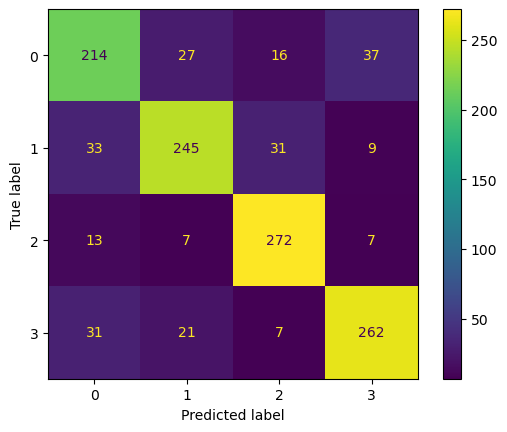

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

In [9]:
model.n_iter_

array([79])

In [10]:
model.coef_

array([[ 0.89086794, -1.92157496, -0.12756289,  0.01865445,  0.11966476,
         0.16738116,  0.20238843,  0.09750034, -0.417858  ,  0.1951801 ,
        -0.06073567, -0.08503251],
       [ 0.97926414,  3.2571345 ,  0.51170985, -0.01510168,  0.49676642,
         0.14207901,  0.18331352,  0.22353808, -0.594246  ,  0.30945683,
        -0.1325872 , -0.22218502],
       [-5.89757097,  2.59540451,  0.18367851, -0.06942144,  0.24748931,
        -0.44536456, -0.51657491, -0.56765628,  1.53021888, -0.69080674,
         0.29986247,  0.3915674 ],
       [ 4.02743889, -3.93096405, -0.56782547,  0.06586866, -0.8639205 ,
         0.13590438,  0.13087296,  0.24661786, -0.51811487,  0.1861698 ,
        -0.10653961, -0.08434988]])

V v informative: correlation coefficient between each feature and target. 

In [11]:
model.intercept_

array([ 1.64648146, -1.37746997,  0.18273813, -0.45174962])